In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
pd.set_option('display.min_rows', 100)

In [3]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [4]:
with open("metrics_basic_10p.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.provider": "provider"
}, inplace=True)
points["end"] = points['start'] + points['duration']

In [5]:
success = points[points["status"] == "success"].sort_values(by='start')
confirmed = points[points["status"] == "confirmed"].sort_values(by='start')
invalid = points[points["status"] == "invalid"].sort_values(by='start')

In [6]:
success.shape, confirmed.shape, invalid.shape

((738, 7), (718, 7), (1166, 7))

In [7]:
success["duration"].median()

3210.652545005083

In [8]:
confirmed["duration"].median()

15298.182890504599

In [9]:
epoches = success[["start", "end"]].copy()
epoches.sort_values(by="start", inplace=True)
td = epoches["start"].diff()
threshold = 20_000 
epoches["epoch"] = (td > threshold).cumsum()

epoches = epoches.groupby("epoch").agg(start=('start', 'min'), end=('start', 'max')).reset_index()
epoches["end"] = epoches["end"] + success["duration"].median()
epoches["duration"] = epoches["end"] - epoches["start"]
epoches = epoches[epoches["duration"] > 50_000].reset_index()

In [10]:
epoches

,index,epoch,start,end,duration
0,0,0,1.897552e+05,5.914834e+05,401728.157884
1,1,1,6.974122e+05,9.809469e+05,283534.736725
2,2,2,1.094200e+06,1.379547e+06,285347.110295
3,3,3,1.501350e+06,1.781210e+06,279859.597300
4,5,5,1.927813e+06,2.205863e+06,278049.774992
5,6,6,2.313162e+06,2.521088e+06,207925.997338


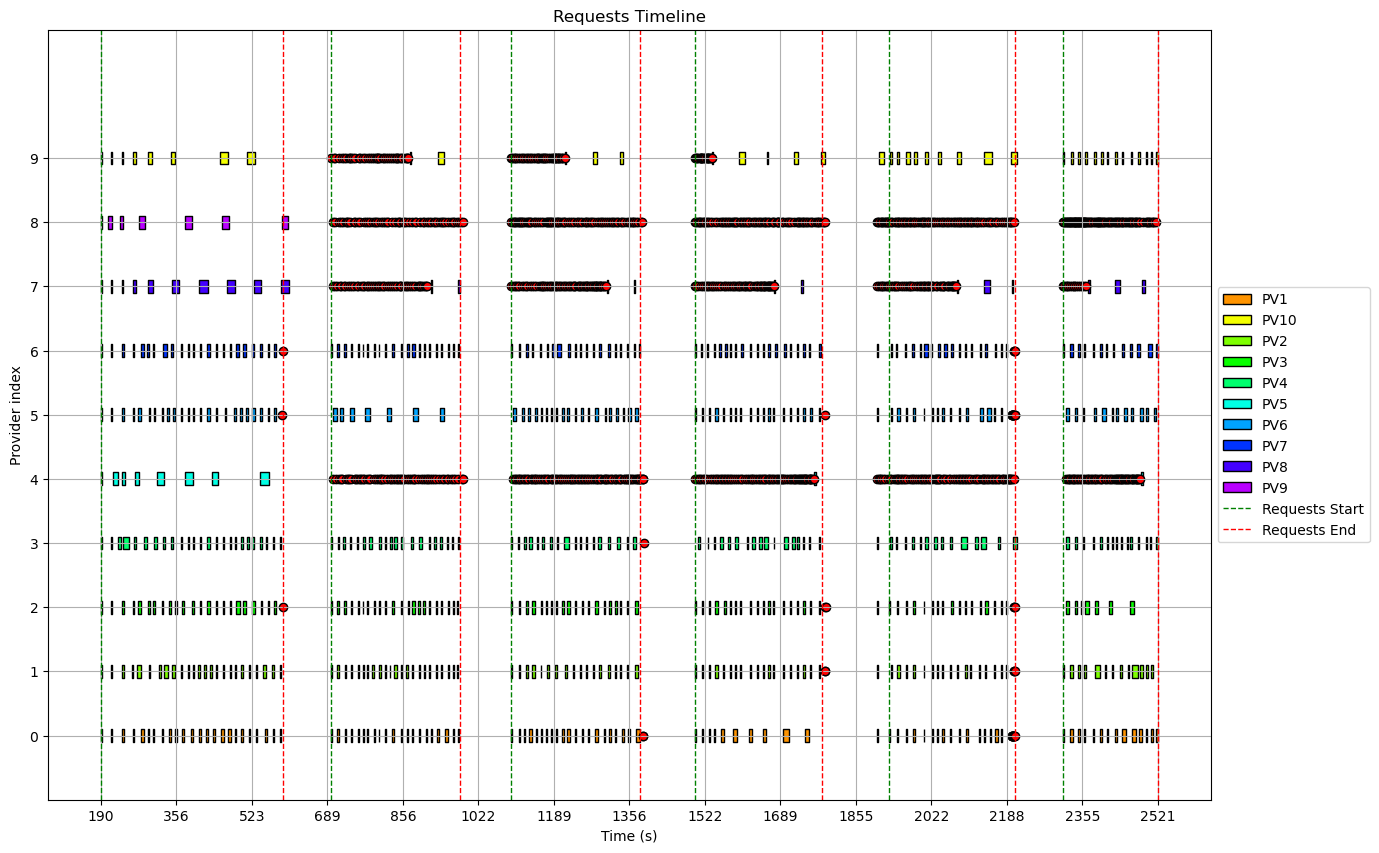

In [11]:
FACTOR = 1e3
count = len(points['provider'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

for i, (pv, group) in enumerate(success.groupby('provider')):
    data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
    pnum = int(pv[2:])
    plt.broken_barh(data, (pnum-1.1, 0.2), edgecolor='black', facecolor=cmap[i], label=pv)

for i, (pv, group) in enumerate(invalid.groupby('provider')):
    data = group['start'] / FACTOR
    pnum = int(pv[2:])
    plt.scatter(data, [pnum - 1] * len(data), edgecolor='black', facecolor="red")

for i, row in epoches.iterrows():
    plt.axvline(x=row['start'] / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    plt.axvline(x=row['end'] / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

# Formatting
plt.xticks(np.linspace(success["start"].min() / FACTOR, success["end"].max() / FACTOR, 15))
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Provider index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

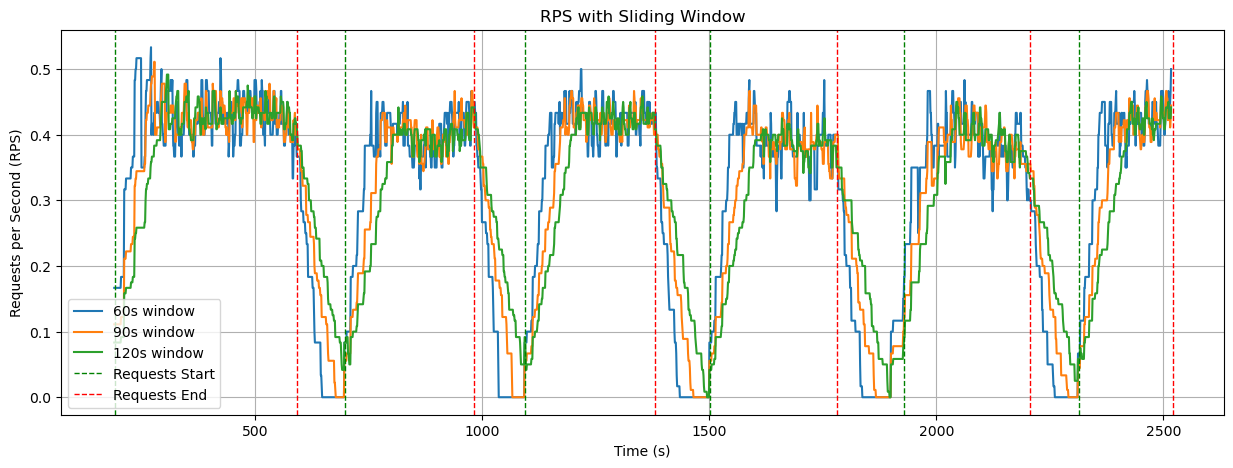

In [12]:
reqs = success[["start"]].copy()
reqs["start"] = pd.to_timedelta(reqs["start"], unit="ms")
reqs = reqs.groupby("start").size().to_frame(name='counts')

# Resample to 1-second frequency
resampled = reqs.resample('1S').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

for i, row in epoches.iterrows():
    start = pd.to_timedelta(row['start'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=start / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    end = pd.to_timedelta(row['end'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=end / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
erps = []
for (i, epoch) in epoches.iterrows():
    count = len(success[(success["start"] > epoch["start"]) & (success["end"] < epoch["end"])])
    rps = count / epoch["duration"] * 1000
    erps.append(rps)
    print(rps)
pd.Series(erps).median()

0.4331287129995734
0.4126478517284904
0.42404494608310683
0.3930542352709625
0.381226706632168
0.43284630662940315


0.4183463989057986

Text(0, 0.5, 'RPS')

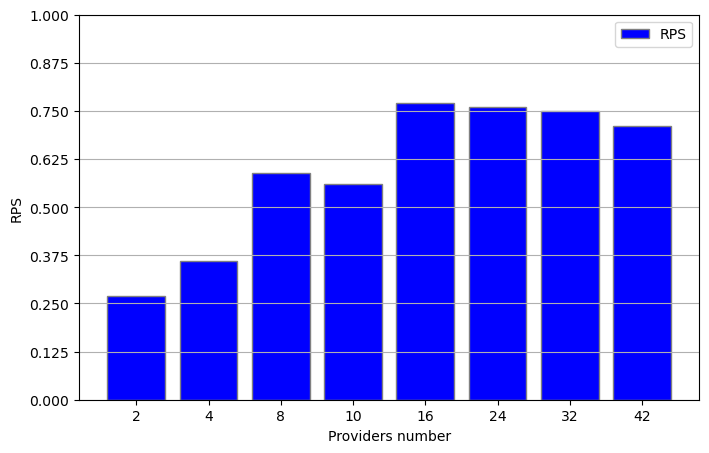

In [14]:
providers =     ["2",  "4",  "8",  "10", "16", "24", "32", "42"]
providers_rps = [0.27, 0.36, 0.59, 0.56, 0.77, 0.76, 0.75, 0.71]
barWidth = 0.8

plt.figure(figsize=(len(providers), 5))

n_providers = len(providers)
rps_x = np.arange(n_providers)

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='RPS')

plt.legend()
plt.grid(True, axis="y")
plt.xticks(range(n_providers), providers)
plt.yticks(np.linspace(0, 1, 9))
plt.xlabel("Providers number")
plt.ylabel("RPS")